In [1]:
import pynwb
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from utils import make_psth, smooth_psth
%matplotlib widget

In [2]:
# Load NWB file
nwb_path = '/data/742903_2024-10-22.nwb'
nwb = pynwb.NWBHDF5IO(nwb_path).read()
trials = nwb.trials.to_dataframe()
units = nwb.units.to_dataframe()

In [3]:
# Filter units to only include good units from manual annotation
unit_qc_file = '/data/manual_qc.csv'
unit_qc = pd.read_csv(unit_qc_file)
units = pd.merge(units,unit_qc,on='unit_id')
units = units[units.manual_qc==True]
units = units[units.firing_rate > 0.5] # Filter out low firing rate units

In [4]:
# Get units from MOs
units = units[units.structure=='MOs']
units.shape

(354, 53)

In [5]:
# Conditions for trial-averaged PSTHs
conditions = {'VsVc':['is_vis_target','is_vis_context'],
              'VsAc':['is_vis_target','is_aud_context'],
               'AsAc':['is_aud_target','is_aud_context'],
              'AsVc':['is_aud_target','is_vis_context']}

In [6]:
# Make DataArray of units, conditions, and time

pre_window = 3
post_window = 4.5
bin_size = 0.002

data = []
all_unit_ids = []
for unit_id in units.unit_id.unique()[:]:
    spike_times = units[units.unit_id == unit_id].spike_times.values[0]
    all_psths = []
    for k,c in conditions.items():
        trials_cond = trials[trials[c].all(axis=1)]
        start_times = trials_cond.stim_start_time.values
        fr, bins = make_psth(spike_times, start_times, pre_window=pre_window, post_window=post_window, bin_size=bin_size)
        fr = smooth_psth(fr,bin_size=bin_size,kernel_type='gaussian',sigma=0.01)
        all_psths.append(fr.mean(axis=0))

    all_psths = np.array(all_psths)
    data.append(all_psths)
    all_unit_ids.append(unit_id)

data = np.array(data)

da = xr.DataArray(data, coords=[all_unit_ids, list(conditions.keys()), bins], dims=['unit_id','condition','time'])

In [7]:
# Function to do PCA on DataArray of neurons

def pca_neurons(data_array, n_components=3):
    # Reshape to (condition*time, neurons)
    X = data_array.stack(samples=('condition', 'time'))
    X = X.transpose('samples', 'unit_id')

    # Standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Fit PCA
    pca = PCA(n_components=n_components)
    projected = pca.fit_transform(X)
    
    # Create new DataArray with PCA results
    pca_da = xr.DataArray(
        projected.reshape(len(data_array.condition), len(data_array.time), n_components),
        dims=['condition', 'time', 'component'],
        coords={
            'condition': data_array.condition,
            'time': data_array.time,
            'component': [f'PC{i+1}' for i in range(n_components)],
            'explained_var': ('component', pca.explained_variance_ratio_),
        }
    )
    return pca_da

In [8]:
# Perform PCA on the DataArray
pca_da = pca_neurons(da, n_components=3)

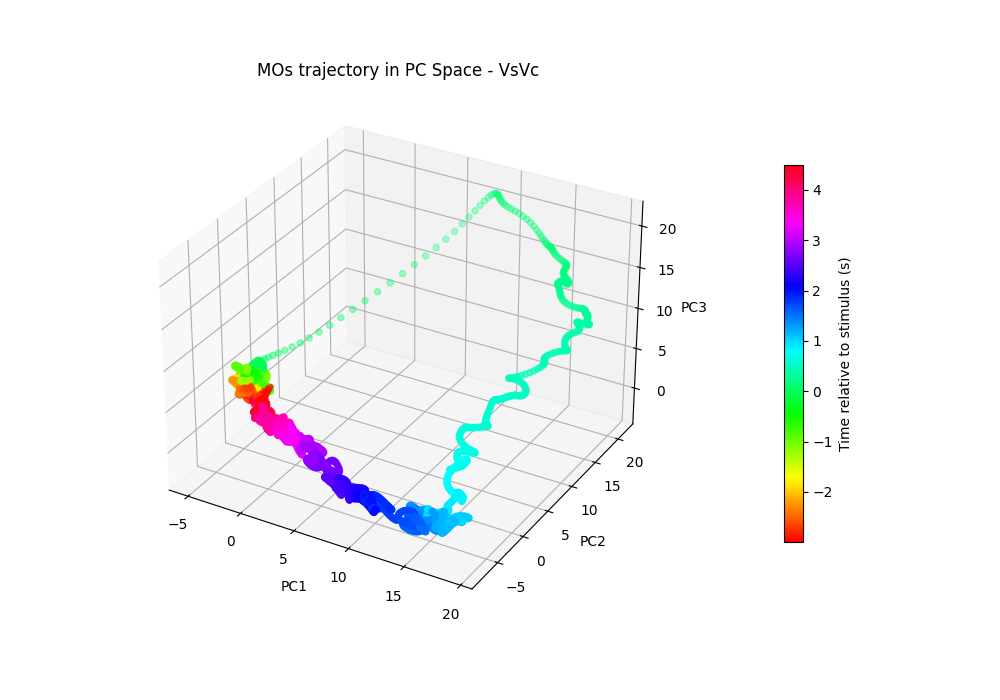

In [9]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pca_da.sel({'component':'PC1','condition':'VsVc'}).values,
                     pca_da.sel({'component':'PC2','condition':'VsVc'}).values,
                     pca_da.sel({'component':'PC3','condition':'VsVc'}).values,
                     c=pca_da.time.values,s=20,label='VIS+_V',cmap='hsv')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('MOs trajectory in PC Space - VsVc')
fig.colorbar(scatter, label='Time relative to stimulus (s)',shrink=0.7,pad=0.15)
plt.show()

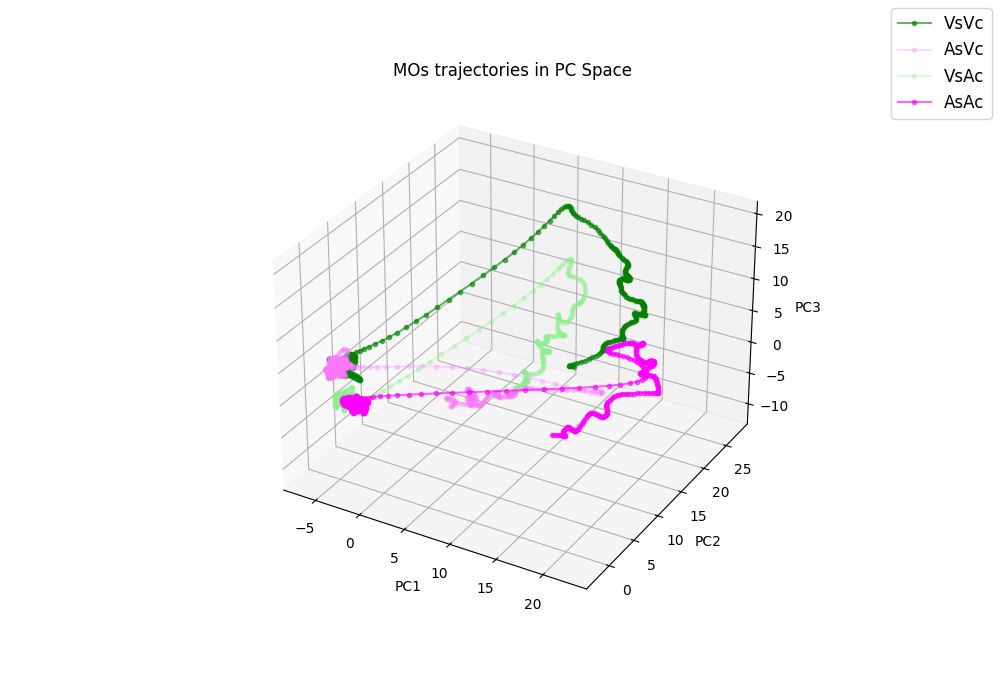

In [10]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

start_time = -1
end_time = 0.5

da_slice = pca_da.sel({'time':slice(start_time,end_time)})  

ax.plot(da_slice.sel({'component':'PC1','condition':'VsVc'}).values,
                     da_slice.sel({'component':'PC2','condition':'VsVc'}).values,
                     da_slice.sel({'component':'PC3','condition':'VsVc'}).values,
                     '-o',color='green',markersize=3,alpha=0.6,label='VsVc')

ax.plot(da_slice.sel({'component':'PC1','condition':'AsVc'}).values,
                     da_slice.sel({'component':'PC2','condition':'AsVc'}).values,
                     da_slice.sel({'component':'PC3','condition':'AsVc'}).values,
                     '-o',color='#FF77FF',markersize=3,alpha=0.25,label='AsVc')

ax.plot(da_slice.sel({'component':'PC1','condition':'VsAc'}).values,
                     da_slice.sel({'component':'PC2','condition':'VsAc'}).values,
                     da_slice.sel({'component':'PC3','condition':'VsAc'}).values,
                     '-o',color='#90EE90',markersize=3,alpha=0.3,label='VsAc')

ax.plot(da_slice.sel({'component':'PC1','condition':'AsAc'}).values,
                     da_slice.sel({'component':'PC2','condition':'AsAc'}).values,
                     da_slice.sel({'component':'PC3','condition':'AsAc'}).values,
                     '-o',color='magenta',markersize=3,alpha=0.6,label='AsAc')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('MOs trajectories in PC Space')
fig.legend(fontsize='large')
plt.show()